![image](https://user-images.githubusercontent.com/92790663/189541779-82e3ea35-da9c-444d-b5d6-3dfe4456c09c.png)

### BUSINESS PROBLEM

Approximately two million managers play the Fantasy Premier League (FPL) for 38 game weeks every season. Every game week, the big question on the two million minds is which soccer players will provide maximum ROI throughout the season. A predictive analytics model for weekly ROI from a player is crucial information sought by FPL managers. This project investigates a model based on the historical data of players' performance against their opponents.

#### BUSINESS OBJECTIVES
- Create a model that predicts points for each player weekly and evaluate the model's accuracy.
- Predict and select players with high returns on fantasy points before every game week.
- Players comparison using analytics.

#### DATA SOURCES 
[Link 1](https://www.fantasynutmeg.com)

- This source provides historical data from the 2016 season till the current season. The extracted data contains only data of players with double digits fantasy points across every fixture in respective seasons. There is an opportunity to extract every player's performance for every fixture from 2016 to the current season. This is an issue to resolve as part of the optimization phase of this project.


[Link 2](https://fantasy.premierleague.com/api/)

- This source is the official FPL API that only contains the data on players’ performance in the current season, players' positions and all the current season fixtures.


#### PERFORMANCE METRICS
- Accuracy.
- R-Squared ($R^2$) score (Coefficient of determination).
- RMSE (Root Mean Squared Error).

### IMPORT NECESSARY LIBRARIES

In [1]:
import os
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

### ACCESSING DATA

In [2]:
# Read data.
df_allseasons = pd.read_csv('cleaned_merged_seasons.csv', index_col = 'Unnamed: 0')
df_allseasons.head()

/tmp/ipykernel_1648/1029439869.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_allseasons = pd.read_csv('cleaned_merged_seasons.csv', index_col = 'Unnamed: 0')


,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,1.0,0.0,1,0,0,0,45,True,1,1


In [3]:
# Print all columns.
df_allseasons.columns

Index(['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [4]:
# Descriptive information on features.
df_allseasons.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98402 entries, 0 to 98401
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           98402 non-null  object 
 1   name               98402 non-null  object 
 2   position           98402 non-null  object 
 3   team_x             48930 non-null  object 
 4   assists            98402 non-null  int64  
 5   bonus              98402 non-null  int64  
 6   bps                98402 non-null  int64  
 7   clean_sheets       98402 non-null  int64  
 8   creativity         98402 non-null  float64
 9   element            98402 non-null  int64  
 10  fixture            98402 non-null  int64  
 11  goals_conceded     98402 non-null  int64  
 12  goals_scored       98402 non-null  int64  
 13  ict_index          98402 non-null  float64
 14  influence          98402 non-null  float64
 15  kickoff_time       98402 non-null  object 
 16  minutes            984

In [5]:
# Check for any missing values.
df_allseasons.isnull().values.any()

True

In [6]:
# Check missing values for each feature.
df_allseasons.isna().sum()

season_x                 0
name                     0
position                 0
team_x               49472
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
element                  0
fixture                  0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
kickoff_time             0
minutes                  0
opponent_team            0
opp_team_name            0
own_goals                0
penalties_missed         0
penalties_saved          0
red_cards                0
round                    0
saves                    0
selected                 0
team_a_score            49
team_h_score            49
threat                   0
total_points             0
transfers_balance        0
transfers_in             0
transfers_out            0
value                    0
was_home                 0
yellow_cards             0
GW                       0
d

In [7]:
df_allseasons.team_x

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
98397      Leicester
98398      Newcastle
98399    Southampton
98400       Brighton
98401       West Ham
Name: team_x, Length: 98402, dtype: object

In [8]:
# Check for duplicates on each row.
df_allseasons.duplicated().value_counts()

False    98402
dtype: int64

In [9]:
# Check for unique values.
df_allseasons.nunique()

season_x                 6
name                   989
position                 4
team_x                  23
assists                  5
bonus                    4
bps                    113
clean_sheets             2
creativity             860
element                737
fixture                380
goals_conceded          10
goals_scored             5
ict_index              273
influence              528
kickoff_time          1428
minutes                 91
opponent_team           20
opp_team_name           31
own_goals                2
penalties_missed         2
penalties_saved          3
red_cards                2
round                   47
saves                   14
selected             65713
team_a_score             9
team_h_score            10
threat                 149
total_points            31
transfers_balance    32217
transfers_in         24344
transfers_out        26734
value                  100
was_home                 2
yellow_cards             2
GW                      47
d

In [10]:
# Descriptive statistics.
df_allseasons.describe()

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW
count,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,98402.000000,...,98353.000000,98353.000000,98402.000000,98402.000000,9.840200e+04,9.840200e+04,9.840200e+04,98402.000000,98402.000000,98402.000000
mean,0.045873,0.122599,6.825359,0.120993,5.352928,311.321701,196.188248,0.542845,0.051279,1.963898,...,1.262097,1.491708,6.127121,1.541798,1.318144e+03,1.395050e+04,1.263175e+04,52.496870,0.057814,20.718309
std,0.227680,0.520794,10.252218,0.326121,11.305636,181.148434,108.663200,0.995002,0.247819,3.218001,...,1.224245,1.310472,14.476371,2.658725,5.859415e+04,5.034220e+04,4.287093e+04,13.123029,0.233392,11.605966
min,0.000000,0.000000,-18.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-7.000000,-1.857821e+06,0.000000e+00,0.000000e+00,37.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,157.000000,103.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,-1.721000e+03,6.400000e+01,1.850000e+02,45.000000,0.000000,11.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,306.000000,200.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,-7.800000e+01,5.870000e+02,1.422000e+03,49.000000,0.000000,21.000000
75%,0.000000,0.000000,12.000000,0.000000,3.900000,459.000000,290.000000,1.000000,0.000000,2.900000,...,2.000000,2.000000,4.000000,2.000000,1.440000e+02,5.894000e+03,8.614750e+03,55.000000,0.000000,30.000000
max,4.000000,3.000000,128.000000,1.000000,170.900000,737.000000,380.000000,9.000000,4.000000,35.800000,...,9.000000,9.000000,186.000000,29.000000,1.983733e+06,2.104464e+06,1.872898e+06,136.000000,1.000000,47.000000


#### Observation
- Some records are missing.
- No duplicate observation.

#### FEATURE ENGINEERING

In [11]:
# Make a copy of the original piece of data.
df_allseasons_clean = df_allseasons.copy()

> To engineer two new features named `club_name` and `form`, we collect data from the `fantasynutmeg` API (Link 1 in the business problem statement), compare the columns of the collected data with the `df_allseasons` dataframe and extract the features highlighted above.

In [12]:
# Get yearly historic data from endpoint for available seasons and identify the keys in each disctionary using 2016 as an example.
Y2016= requests.get('https://www.fantasynutmeg.com/api/history/season/2016-17').json()
Y2017= requests.get('https://www.fantasynutmeg.com/api/history/season/2017-18').json()
Y2018= requests.get('https://www.fantasynutmeg.com/api/history/season/2018-19').json()
Y2019= requests.get('https://www.fantasynutmeg.com/api/history/season/2019-20').json()
Y2020= requests.get('https://www.fantasynutmeg.com/api/history/season/2020-21').json()
Y2021= requests.get('https://www.fantasynutmeg.com/api/history/season/2021-22').json()
Y2022= requests.get('https://www.fantasynutmeg.com/api/history/season/2022-23').json()

Y2016.keys()

dict_keys(['dd_agg_fixture', 'dd_agg_player', 'dd_hauls', 'history'])

In [13]:
# Convert history data dictionary to a pandas dataframe.
hist16_df = pd.DataFrame(Y2016['history'])
hist17_df = pd.DataFrame(Y2017['history'])
hist18_df = pd.DataFrame(Y2018['history'])
hist19_df = pd.DataFrame(Y2019['history'])
hist20_df = pd.DataFrame(Y2020['history'])
hist21_df = pd.DataFrame(Y2021['history'])

In [14]:
# Engineer feature to highlight each season year.
hist16_df['year'] = hist16_df.apply(lambda x: "2016-17", axis=1)
hist17_df['year'] = hist17_df.apply(lambda x: "2017-18", axis=1)
hist18_df['year'] = hist18_df.apply(lambda x: "2018-19", axis=1)
hist19_df['year'] = hist19_df.apply(lambda x: "2019-20", axis=1)
hist20_df['year'] = hist20_df.apply(lambda x: "2020-21", axis=1)
hist21_df['year'] = hist21_df.apply(lambda x: "2021-22", axis=1)

In [15]:
# Concatenate all history data across years.
hist_df = [hist16_df, hist17_df, hist18_df, hist19_df, hist20_df, hist21_df]

hist = pd.concat(hist_df, axis = 0, ignore_index=True)

In [16]:
# Preview history data.
hist.head()

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,code,cost_change_event,cost_change_event_fall,cost_change_start,...,influence_rank,influence_rank_type,threat_rank,threat_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0,0,18,100,100,0,48844,0,0,-3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,660,100,100,12,11334,0,0,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,19,723,0,75,10,51507,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,5,100,100,0,17127,0,0,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,296,75,100,5,158074,0,0,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Engineer feature to highlight the form of the players.
hist['form'] = hist['total_points']/38 

In [18]:
# Print all columns.
hist.columns

Index(['assists', 'bonus', 'bps', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'clean_sheets', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'creativity', 'dreamteam_count', 'ea_index',
       'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name',
       'form', 'goals_conceded', 'goals_scored', 'ict_index', 'id',
       'in_dreamteam', 'influence', 'loaned_in', 'loaned_out', 'loans_in',
       'loans_out', 'minutes', 'news', 'now_cost', 'own_goals',
       'penalties_missed', 'penalties_saved', 'photo', 'points_per_game',
       'position', 'red_cards', 'saves', 'second_name', 'selected_by_percent',
       'special', 'squad_number', 'status', 'team', 'team_code', 'team_name',
       'threat', 'total_points', 'transfers_in', 'transfers_in_event',
       'transfers_out', 'transfers_out_event', 'value_form', 'value_season',
       'web_name', 'yellow_cards', 'year', 'news_added', 

We have the historical data from 16-21. We proceed as described below:
1. Create a column with the First Name, Last Name and the Year. 
2. Combine the name and the year of the df_`allseasons` dataframe to match the historical data. 
3. Map the two based on the First Name, Last Name and the Year and extract needed features.

In [19]:
# Engineer feature to highlight the players name and the season they played in.
hist['name_season'] = hist['first_name'] + ' ' + hist['second_name'] + '_' + hist['year']

In [20]:
# Display a sample of name_season column.
hist.name_season.head()

0                David Ospina_2016-17
1                   Petr Cech_2016-17
2           Laurent Koscielny_2016-17
3             Per Mertesacker_2016-17
4    Gabriel Armando de Abreu_2016-17
Name: name_season, dtype: object

In [21]:
# Data Quality Checks.
subset  = ['Mohamed Salah_2018-19']
check = hist[hist.name_season.isin(subset)]
check.form

1582    6.815789
Name: form, dtype: float64

In [22]:
# Engineer feature to highlight the players name and the season they played in.
df_allseasons_clean['name_season'] = df_allseasons_clean['name'] + '_' + df_allseasons_clean['season_x']

In [23]:
# Engineer a feature to highlight the club of the player.
teams=dict(zip(hist.name_season, hist.team_name))

df_allseasons_clean['club_name'] = df_allseasons_clean['name_season'].map(teams)

In [24]:
# Engineer a feature to highlight the form of the player.
teams=dict(zip(hist.name_season, hist.form))

df_allseasons_clean['form'] = df_allseasons_clean['name_season'].map(teams)

In [25]:
# Preview dataframe.
df_allseasons_clean.head()

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,name_season,club_name,form
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,0,0,0,55,False,0,1,Aaron Cresswell_2016-17,WHU,1.578947
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,0,0,0,60,True,0,1,Aaron Lennon_2016-17,EVE,0.578947
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,0,0,0,80,True,0,1,Aaron Ramsey_2016-17,ARS,1.473684
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,0,0,0,50,False,0,1,Abdoulaye Doucouré_2016-17,WAT,1.000000
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,0,0,0,45,True,1,1,Adam Forshaw_2016-17,MID,2.026316


In [26]:
# Data Quality Checks.
subset  = ['Marcus Rashford_2020-21']
check = df_allseasons_clean[df_allseasons_clean.name_season.isin(subset)]
check.form

50237    4.578947
50787    4.578947
51344    4.578947
51917    4.578947
52611    4.578947
53207    4.578947
53807    4.578947
54408    4.578947
55010    4.578947
55566    4.578947
56157    4.578947
56764    4.578947
57374    4.578947
57988    4.578947
58498    4.578947
59044    4.578947
59480    4.578947
60327    4.578947
60328    4.578947
61026    4.578947
61674    4.578947
62336    4.578947
63001    4.578947
63780    4.578947
64523    4.578947
65608    4.578947
65609    4.578947
65890    4.578947
66643    4.578947
67606    4.578947
68293    4.578947
68985    4.578947
69666    4.578947
70880    4.578947
70881    4.578947
70882    4.578947
72475    4.578947
73181    4.578947
Name: form, dtype: float64

In [27]:
# Print all columns.
df_allseasons_clean.columns

Index(['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW', 'name_season', 'club_name', 'form'],
      dtype='object')

In [28]:
# Engineer feature to highlight the game dates from kickoff_time.
df_allseasons_clean['game_date'] = df_allseasons_clean['kickoff_time'].str.replace('T', ' ')
df_allseasons_clean['game_date'] = df_allseasons_clean['game_date'].str.replace(':00Z', '')

In [29]:
# Preview series.
df_allseasons_clean.game_date.head()

0    2016-08-15 19:00
1    2016-08-13 14:00
2    2016-08-14 15:00
3    2016-08-13 14:00
4    2016-08-13 14:00
Name: game_date, dtype: object

In [30]:
# Convert game_date feature to appropriate dtype.
df_allseasons_clean['game_date'] = pd.to_datetime(df_allseasons_clean['game_date'])

In [31]:
# Preview series.
df_allseasons_clean.game_date.head()

0   2016-08-15 19:00:00
1   2016-08-13 14:00:00
2   2016-08-14 15:00:00
3   2016-08-13 14:00:00
4   2016-08-13 14:00:00
Name: game_date, dtype: datetime64[ns]

In [32]:
# Engineer game season weather feature.
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

month_to_season = dict(zip(range(1,13), seasons))
df_allseasons_clean['game_weather'] = df_allseasons_clean.game_date.dt.month.map(month_to_season) 

In [33]:
# Data Quality Check.
df_allseasons_clean.game_weather.value_counts()

1    36939
2    26810
4    24533
3    10120
Name: game_weather, dtype: int64

In [34]:
# Engineer feature to highlights games that started before 13:00 (early starts) and those that started after 13:00 (late starts)
df_allseasons_clean['start_label'] = np.where((df_allseasons_clean['game_date'].dt.hour) < 13, 0, 1)

In [35]:
# Quality Check.
df_allseasons_clean[['game_date', 'start_label']].head(20)

,game_date,start_label
0,2016-08-15 19:00:00,1
1,2016-08-13 14:00:00,1
2,2016-08-14 15:00:00,1
3,2016-08-13 14:00:00,1
4,2016-08-13 14:00:00,1
5,2016-08-14 15:00:00,1
6,2016-08-15 19:00:00,1
7,2016-08-14 15:00:00,1
8,2016-08-13 14:00:00,1
9,2016-08-14 15:00:00,1


In [36]:
# Descriptive information on all features.
df_allseasons_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98402 entries, 0 to 98401
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   season_x           98402 non-null  object        
 1   name               98402 non-null  object        
 2   position           98402 non-null  object        
 3   team_x             48930 non-null  object        
 4   assists            98402 non-null  int64         
 5   bonus              98402 non-null  int64         
 6   bps                98402 non-null  int64         
 7   clean_sheets       98402 non-null  int64         
 8   creativity         98402 non-null  float64       
 9   element            98402 non-null  int64         
 10  fixture            98402 non-null  int64         
 11  goals_conceded     98402 non-null  int64         
 12  goals_scored       98402 non-null  int64         
 13  ict_index          98402 non-null  float64       
 14  influe

In [37]:
# Check missing values for each feature.
df_allseasons_clean.isna().sum()

season_x                 0
name                     0
position                 0
team_x               49472
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
element                  0
fixture                  0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
kickoff_time             0
minutes                  0
opponent_team            0
opp_team_name            0
own_goals                0
penalties_missed         0
penalties_saved          0
red_cards                0
round                    0
saves                    0
selected                 0
team_a_score            49
team_h_score            49
threat                   0
total_points             0
transfers_balance        0
transfers_in             0
transfers_out            0
value                    0
was_home                 0
yellow_cards             0
GW                       0
n

In [38]:
# Check the Nan values in team_a_score and team_h_score.
filt = df_allseasons_clean['team_a_score'].isna() == True
df_allseasons_clean.loc[filt, 'team_h_score']

44426   NaN
44428   NaN
44430   NaN
44444   NaN
44450   NaN
44453   NaN
44458   NaN
44465   NaN
44485   NaN
44490   NaN
44494   NaN
44498   NaN
44502   NaN
44505   NaN
44510   NaN
44514   NaN
44521   NaN
44535   NaN
44549   NaN
44559   NaN
44572   NaN
44574   NaN
44589   NaN
44602   NaN
44616   NaN
44622   NaN
44624   NaN
44627   NaN
44630   NaN
44656   NaN
44658   NaN
44681   NaN
44691   NaN
44700   NaN
44714   NaN
44728   NaN
44736   NaN
44740   NaN
44761   NaN
44769   NaN
44785   NaN
44807   NaN
44839   NaN
44856   NaN
44866   NaN
44870   NaN
44872   NaN
44902   NaN
44917   NaN
Name: team_h_score, dtype: float64

#### Observation
- `team_x` can be dropped since another feature (`club_name`) that highlights the name of the clubs of the players has been engineered.
- The features (`team_a_score` and `team_h_score`, `club_name`, `form`) have missing values for the same observations (49 observations). The observations can thus be comfortably dropped.

#### Data Quality
Data quality issues are mostly divided into four:
- Completeness: do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?
- Validity: we have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).
- Accuracy: inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect.
- Consistency: inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

After assessing the data, we have the following issues:

1. Missing data (`team_x`, `team_a_score`, `team_h_score`, `club_name`, `form`).
2. Erroneous data types (`team_a_score`, `team_h_score`).
3. Redundant features (`opponent_team` and `opp_team_name`, `kickoff_time` and `game_date`)

#### Data Tidiness
There are three main requirements for tidiness.

1. Each variable forms a column,
2. Each observation forms a row, and
3. Each type of observational unit forms a table.

The three above criteria's are fairly met by the dataset.

### CLEANING DATA

In [39]:
# Make a copy of the original piece of data.
df_allseasons_final = df_allseasons_clean.copy()

#### QUALITY ISSUES

#### Issue #1:
- Missing data (`team_x`, `team_a_score`, `team_h_score`, `club_name`, `form`)

#### Define
- Drop `team_x` column.
- Drop all missing observations.

#### Code

In [40]:
# Drop feature.
df_allseasons_final.drop('team_x', axis = 1, inplace=True)

# Drop all missing observations.
df_allseasons_final.dropna(inplace=True)

#### Test

In [41]:
# Descriptive information on all features.
df_allseasons_final.columns

Index(['season_x', 'name', 'position', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW', 'name_season', 'club_name', 'form',
       'game_date', 'game_weather', 'start_label'],
      dtype='object')

In [42]:
# Check missing values for each feature.
df_allseasons_final.isna().sum()

season_x             0
name                 0
position             0
assists              0
bonus                0
bps                  0
clean_sheets         0
creativity           0
element              0
fixture              0
goals_conceded       0
goals_scored         0
ict_index            0
influence            0
kickoff_time         0
minutes              0
opponent_team        0
opp_team_name        0
own_goals            0
penalties_missed     0
penalties_saved      0
red_cards            0
round                0
saves                0
selected             0
team_a_score         0
team_h_score         0
threat               0
total_points         0
transfers_balance    0
transfers_in         0
transfers_out        0
value                0
was_home             0
yellow_cards         0
GW                   0
name_season          0
club_name            0
form                 0
game_date            0
game_weather         0
start_label          0
dtype: int64

#### Issue #2:
- Erroneous data types (`team_a_score`, `team_h_score`).

#### Define
- Convert features to their appropriate data types (int).

#### Code

In [43]:
# Change dypes.
df_allseasons_final['team_h_score'] = df_allseasons_final['team_h_score'].astype(int)
df_allseasons_final['team_a_score'] = df_allseasons_final['team_a_score'].astype(int)

#### Test

In [44]:
# Check dtype.
df_allseasons_final[['team_h_score', 'team_a_score']].dtypes

team_h_score    int64
team_a_score    int64
dtype: object

#### Issue #3:
- Redundant features (`opponent_team` and `opp_team_name`, `kickoff_time` and `game_date`)

#### Define
- Drop `opponent_team` and `kickoff_time`.

#### Code

In [45]:
# Drop features.
df_allseasons_final.drop(['opponent_team', 'kickoff_time'], axis = 1, inplace=True)

#### Test

In [46]:
# Print all columns.
df_allseasons_final.columns

Index(['season_x', 'name', 'position', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'opp_team_name',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'GW', 'name_season', 'club_name',
       'form', 'game_date', 'game_weather', 'start_label'],
      dtype='object')

#### REFACTORING DATA

- Drop features that are not needed for modeling (`season_x`, `name`, `name_season`, `fixture`, `game_date`, `round`)
- Drop all players that had zero playtime.
- Convert dataframe to a time series by making `game_date` the index.

In [47]:
# Drop features.
df_allseasons_final.drop(['season_x', 'name', 'name_season', 'fixture', 'round', 'element'], axis=1, inplace=True)

# Descriptive information.
df_allseasons_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98315 entries, 0 to 98401
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   position           98315 non-null  object        
 1   assists            98315 non-null  int64         
 2   bonus              98315 non-null  int64         
 3   bps                98315 non-null  int64         
 4   clean_sheets       98315 non-null  int64         
 5   creativity         98315 non-null  float64       
 6   goals_conceded     98315 non-null  int64         
 7   goals_scored       98315 non-null  int64         
 8   ict_index          98315 non-null  float64       
 9   influence          98315 non-null  float64       
 10  minutes            98315 non-null  int64         
 11  opp_team_name      98315 non-null  object        
 12  own_goals          98315 non-null  int64         
 13  penalties_missed   98315 non-null  int64         
 14  penalt

In [48]:
# Drop all players with zero playtime.
zero_minutes = df_allseasons_final[df_allseasons_final.minutes == 0].index
df_allseasons_final.drop(zero_minutes, axis = 0, inplace=True)

# Descriptive info.
df_allseasons_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49194 entries, 1 to 98399
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   position           49194 non-null  object        
 1   assists            49194 non-null  int64         
 2   bonus              49194 non-null  int64         
 3   bps                49194 non-null  int64         
 4   clean_sheets       49194 non-null  int64         
 5   creativity         49194 non-null  float64       
 6   goals_conceded     49194 non-null  int64         
 7   goals_scored       49194 non-null  int64         
 8   ict_index          49194 non-null  float64       
 9   influence          49194 non-null  float64       
 10  minutes            49194 non-null  int64         
 11  opp_team_name      49194 non-null  object        
 12  own_goals          49194 non-null  int64         
 13  penalties_missed   49194 non-null  int64         
 14  penalt

In [49]:
# Make season_x the index.
df_allseasons_final.set_index('game_date', inplace=True)

df_allseasons_final.head()

,position,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,transfers_in,transfers_out,value,was_home,yellow_cards,GW,club_name,form,game_weather,start_label
game_date,,,,,,,,,,,,,,,,,,,,,
2016-08-13 14:00:00,MID,0,0,6,0,0.3,0,0,0.9,8.2,...,0,0,60,True,0,1,EVE,0.578947,3,1
2016-08-14 15:00:00,MID,0,0,5,0,4.9,3,0,3.0,2.2,...,0,0,80,True,0,1,ARS,1.473684,3,1
2016-08-13 14:00:00,MID,0,0,3,0,1.3,1,0,0.3,2.0,...,0,0,45,True,1,1,MID,2.026316,3,1
2016-08-14 15:00:00,MID,1,2,33,0,33.7,3,1,14.2,51.2,...,0,0,70,False,1,1,LIV,3.657895,3,1
2016-08-15 19:00:00,GK,0,0,16,0,0.0,2,0,3.0,29.8,...,0,0,50,False,0,1,WHU,1.684211,3,1


### EXPLORATORY DATA ANALYSIS

In [83]:
# Filter for players with point > 0.
total_points = df_allseasons_final.query('total_points > 0')['total_points']

In [84]:
total_points

game_date
2016-08-13 14:00:00     1
2016-08-14 15:00:00     2
2016-08-13 14:00:00     1
2016-08-14 15:00:00    11
2016-08-15 19:00:00     2
                       ..
2022-05-22 15:00:00     1
2022-05-22 15:00:00     1
2022-05-22 15:00:00     2
2022-05-22 15:00:00     1
2022-05-22 15:00:00     2
Name: total_points, Length: 46552, dtype: int64

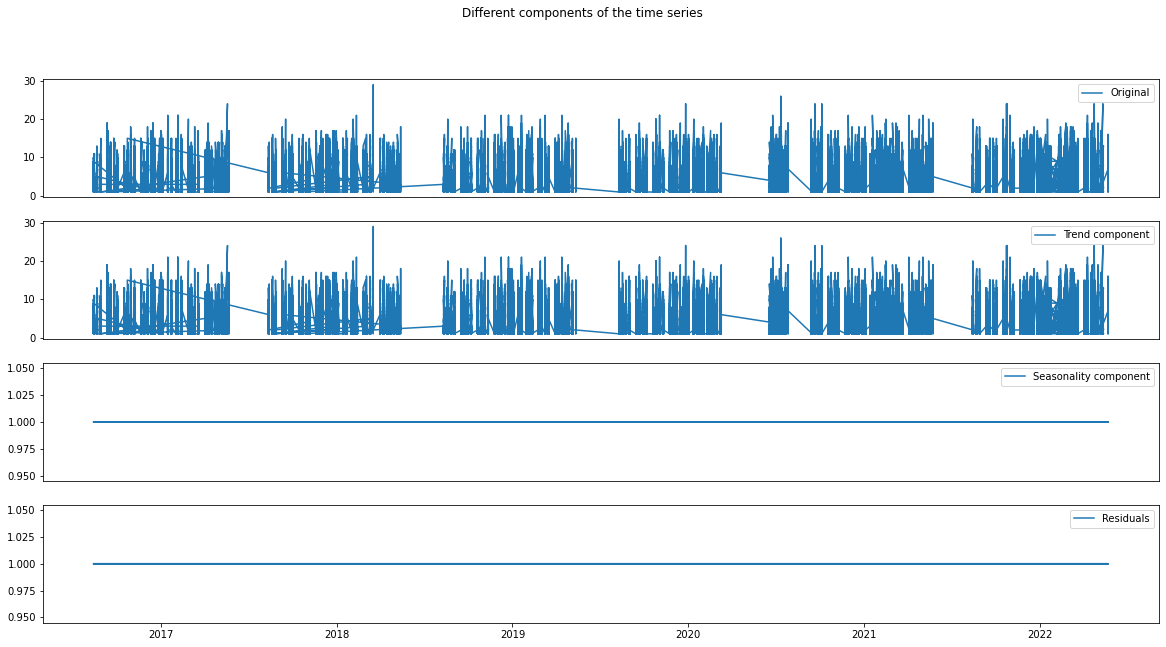

In [86]:
# Decomposing the series into its three components namely "Trend", "Seasonality" and "Residuals"
decomposed = seasonal_decompose(total_points, period=1, model='multiplicative')
trend = decomposed.trend
seasonal = decomposed.seasonal
residuals = decomposed.resid

# Plotting the different components as well as the original series to see how each component is contributing to the series
plt.figure(figsize=(20,10))
fig = plt.figure(1)
fig.suptitle('Different components of the time series')

plt.subplot(411)
plt.plot(total_points, label='Original')
plt.xticks([])
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend component')
plt.xticks([])
plt.legend()

plt.subplot(413)
plt.plot(seasonal, label='Seasonality component')
plt.xticks([])
plt.legend()

plt.subplot(414)
plt.plot(residuals, label='Residuals')
plt.legend()
plt.show()